# GRO620 - Activité procédurale 3

In [34]:
# Préambule

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

## Si vous utilisez Google Colab, vous devez d'abord monter votre Google Drive
## où se trouve vos données. 
## Commentez les trois lignes suivantes en ajustant le chemin vers votre propre
## dossier :

# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/gro620-e21

## Pour retrouver le chemin depuis Jupyter, vous pouvez utiliser ceci :
# !ls /content/gdrive/MyDrive

## Filtrage linéaire - suite

### Q1.1

Soit cette image :

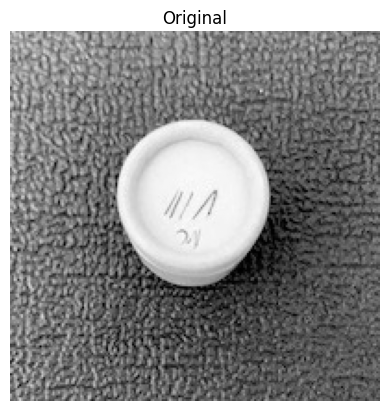

In [35]:
img_q11_org = cv.imread("images_doc/proc2-q1-object.jpeg")
assert img_q11_org is not None
img_q11_mono = np.float32(cv.cvtColor(img_q11_org, cv.COLOR_BGR2GRAY)) / 255.0

plt.imshow(img_q11_mono, cmap="gray")
plt.title("Original"), plt.axis("off")

plt.show()

Utilisez un filtre linéaire de Sobel (voir sections 3.2.1 et 4.2.1) pour faire ressortir les contours de cette image.

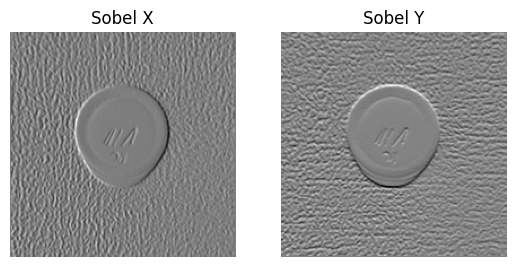

In [36]:
sobelx = cv.Sobel(img_q11_mono, cv.CV_32F, 1, 0, ksize=3)  # type: ignore
sobely = cv.Sobel(img_q11_mono, cv.CV_32F, 0, 1, ksize=3)  # type: ignore

plt.subplot(1, 2, 1), plt.imshow(sobelx, "gray")
plt.title("Sobel X"), plt.axis("off")
plt.subplot(1, 2, 2), plt.imshow(sobely, "gray")
plt.title("Sobel Y"), plt.axis("off")

plt.show()


## Filtrage non-linéaire

### Q2.1

Soit cette image :

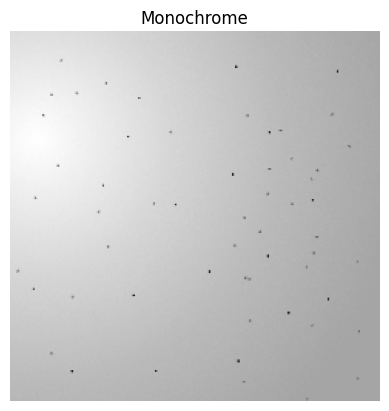

In [37]:
img_q21_org = cv.imread("images_doc/proc2-q3-sand.png")
assert img_q21_org is not None
img_q21_mono = cv.cvtColor(img_q21_org, cv.COLOR_BGR2GRAY)

plt.imshow(img_q21_mono, cmap="gray")
plt.title("Monochrome"), plt.axis("off")

plt.show()

Utilisez un filtre **non-linéaire** pour tenter de retirer les points noirs dans l'image.

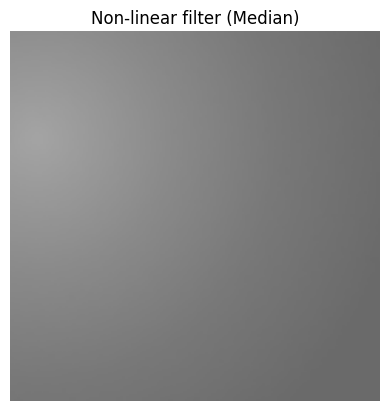

In [38]:
img_q21_filt = img_q21_mono.copy()

img_q21_filt = cv.medianBlur(img_q21_mono, ksize=5)
rgb = cv.cvtColor(img_q21_filt, cv.COLOR_GRAY2RGB)

plt.imshow(rgb)
plt.title("Non-linear filter (Median)"), plt.axis("off")

plt.show()

## Chaîne de filtrage

### Q3.1

En reprenant la figure originale de la question Q1.1, appliquez une succession de filtres pour mieux isoler le contour de l'objet au centre de l'image.

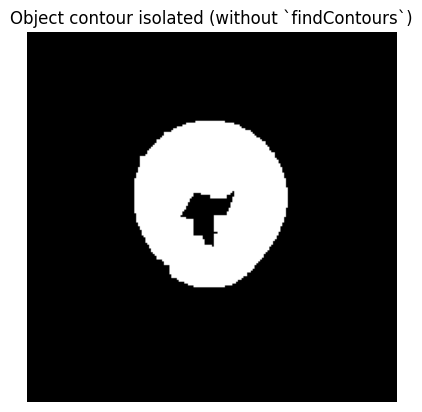

In [39]:
original = img_q11_org.copy()
gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)

blurred = cv.GaussianBlur(original, (9, 9), 1.0)

hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)

laplacian = cv.Laplacian(gray, -1)

closing = cv.morphologyEx(laplacian, cv.MORPH_CLOSE, np.ones((9, 9), dtype=np.uint8))

_, binary_inv = cv.threshold(closing, 65.0, 200.0, cv.THRESH_BINARY_INV)

plt.imshow(binary_inv, "gray")
plt.title("Object contour isolated (without `findContours`)"), plt.axis("off")

plt.show()

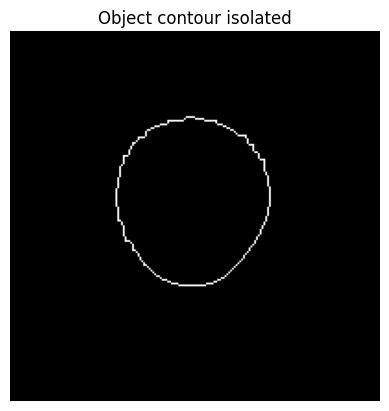

In [40]:
gray = cv.cvtColor(img_q11_org, cv.COLOR_BGR2GRAY)  # type: ignore
hsv = cv.cvtColor(img_q11_org, cv.COLOR_BGR2HSV)  # type: ignore

# Define yellow range in HSV
lower_yellow = np.array([0, 100, 100])
upper_yellow = np.array([100, 255, 255])
mask_hsv = cv.inRange(hsv, lower_yellow, upper_yellow)

lum = gray.mean()  # Luminosity measured from mean of RGB channels
lum_thresh = 130  # NOTE: adjust luminosity threshold as needed
mask_lum = lum > lum_thresh

mask_combined = mask_hsv | mask_lum

result = gray.copy()
result[mask_combined == 0] = 0

# Clean the remaining noise (upper left corner) using morphological transformations
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
mask_clean = cv.morphologyEx(mask_combined.astype(np.uint8), cv.MORPH_OPEN, kernel)
result[mask_clean == 0] = 0

contours, _ = cv.findContours(result, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_only = np.zeros_like(mask_clean)

cv.drawContours(contours_only, contours, -1, 255, thickness=1)

plt.figure(1)
plt.imshow(contours_only, "gray")
plt.title("Object contour isolated")
plt.axis("off")

plt.show()

### Q3.2

Répétez l'exercice précédent, mais avec un filtre de Canny.

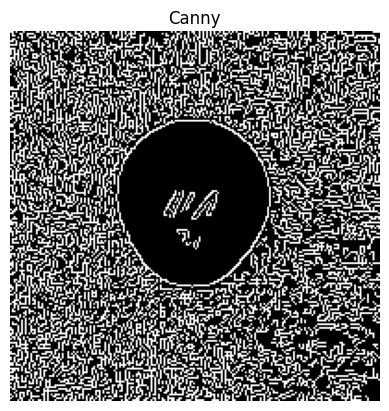

In [41]:
img_q32 = (img_q11_mono * 255.0).astype(np.uint8)

edges = cv.Canny(img_q32, 100.0, 200.0)

plt.imshow(edges, "gray")
plt.title("Canny"), plt.axis("off")

plt.show()

## Analyse de formes

### Q4.1

Soit cette image :

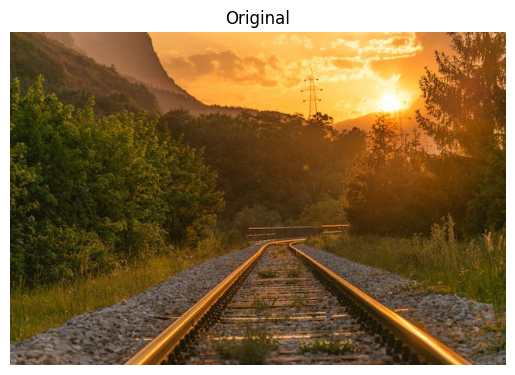

In [42]:
img_q41_org = cv.imread("images_doc/proc3-q4-tracks.jpeg")
assert img_q41_org is not None

img_q41_rgb = cv.cvtColor(img_q41_org, cv.COLOR_BGR2RGB)

plt.imshow(img_q41_rgb)
plt.title("Original"), plt.axis("off")

plt.show()

(Source de l'image originale : [Krivec Ales, Pexels](https://www.pexels.com/photo/clouds-cloudy-country-distance-552779/))

Trouvez et tracez les lignes dominantes à l'aide de la transformée de Hough.

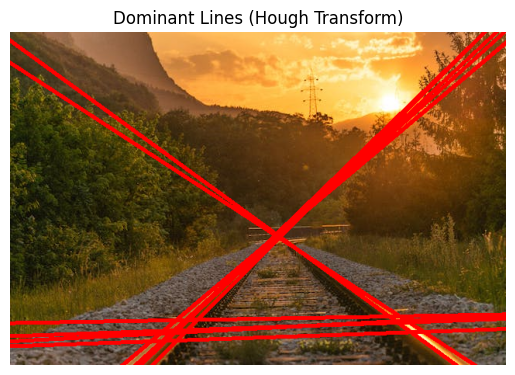

In [43]:
img_q41_mono = cv.cvtColor(img_q41_rgb, cv.COLOR_BGR2GRAY)

edges = cv.Canny(img_q41_mono, 100, 200)
lines = cv.HoughLines(edges, 1, np.pi / 180, threshold=200)

img_q41_lines = img_q41_rgb.copy()
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * -b)
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * -b)
        y2 = int(y0 - 1000 * a)
        cv.line(img_q41_lines, (x1, y1), (x2, y2), (255, 0, 0), 3)

plt.imshow(img_q41_lines)
plt.title("Dominant Lines (Hough Transform)"), plt.axis("off")

plt.show()

### Q4.2

En reprenant l'image des questions Q1.1 et Q3.1, trouvez, tracez et afficher les coordonnées (en pixels) de la boîte (*bounding box*) contenant les contours de l'objet à l'aide de cv2.findContours()

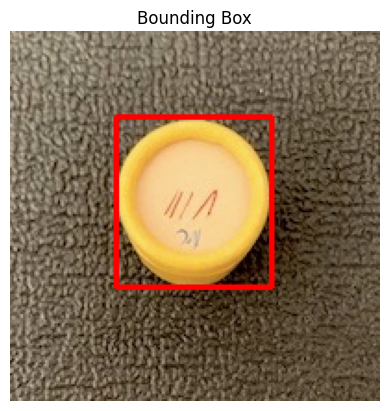

In [44]:
bbox = cv.boundingRect(contours_only)

rgb = cv.cvtColor(img_q11_org, cv.COLOR_BGR2RGB)

x, y, w, h = bbox
cv.rectangle(rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(rgb)
plt.title("Bounding Box")
plt.axis("off")

plt.imshow(rgb)

plt.show()